<a href="https://colab.research.google.com/github/reachsidd/fina_project_6740/blob/main/python/FinalProject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import string

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import sklearn.model_selection
nltk.download('punkt')
nltk.download('stopwords')
import bs4
import wordcloud

import keras.preprocessing
import tensorflow as tf
import zipfile

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# get raw text from htmls
def clean_html(text):
    soup = bs4.BeautifulSoup(text, 'html.parser')
    return soup.get_text()

In [3]:
# remove stopwords, punctuations and lower the case
def remove_stopwords_case_normalization(text):
    stopwords = nltk.corpus.stopwords.words('english')
    #print(stopwords)
    text_new = text.lower()
    text_new = re.sub('[^a-z]', ' ', text_new)
    # print(text_new)
    text_new = "".join([i for i in text_new if i not in string.punctuation])
    #print(text_new)
    words = text_new.split()
    #print(words)
    text_new = " ".join([i for i in words if i not in stopwords])
    #print(text_new)
    return text_new

In [4]:
def clean_text(text):
    # Remove urls
    text_new = re.sub(r'http\S+', '', text)
    text_new = clean_html(text_new)
    text_new = remove_stopwords_case_normalization(text_new)
    return text_new

In [14]:
train_github_url='https://github.com/reachsidd/fina_project_6740/blob/main/data/train.zip?raw=true'
test_github_url='https://github.com/reachsidd/fina_project_6740/blob/main/data/test.zip?raw=true'
submit_github_url='https://github.com/reachsidd/fina_project_6740/blob/main/data/submit.zip?raw=true'

train = pd.read_csv(train_github_url,compression='zip')
test = pd.read_csv(test_github_url,compression='zip')
submit = pd.read_csv(submit_github_url,compression='zip')
test = test.merge(submit, on='id')
print(train.head())
print(test.head())

# null check
print(train.isna().sum())
# null check
print(test.isna().sum())

# filling NULL values with empty string
train = train.fillna('')
test = test.fillna('')


   id  ... label
0   0  ...     1
1   1  ...     0
2   2  ...     1
3   3  ...     1
4   4  ...     1

[5 rows x 5 columns]
      id  ... label
0  20800  ...     0
1  20801  ...     1
2  20802  ...     0
3  20803  ...     1
4  20804  ...     1

[5 rows x 5 columns]
id           0
title      558
author    1957
text        39
label        0
dtype: int64
id          0
title     122
author    503
text        7
label       0
dtype: int64


In [6]:
#FOR TESTING ONLY
#train = train.head(100)
#test = test.head(100)

In [15]:
train['content'] = train['text'] + ' ' + train['title']
train.drop(columns=['title', 'text', 'author', 'id'], inplace=True)

test['content'] = test['text'] + ' ' + test['title']
test.drop(columns=['title', 'text', 'author', 'id'], inplace=True)

train['content'] = train['content'].apply(clean_text)
print(train.head())

test['content'] = test['content'].apply(clean_text)
print(test.head())

   label                                            content
0      1  house dem aide even see comey letter jason cha...
1      0  ever get feeling life circles roundabout rathe...
2      1  truth might get fired october tension intellig...
3      1  videos civilians killed single us airstrike id...
4      1  print iranian woman sentenced six years prison...
   label                                            content
0      0  palo alto calif years scorning political proce...
1      1  russian warships ready strike terrorists near ...
2      0  videos nodapl native american leaders vow stay...
3      1  first succeed try different sport tim tebow he...
4      1  mins ago views comments likes first time histo...


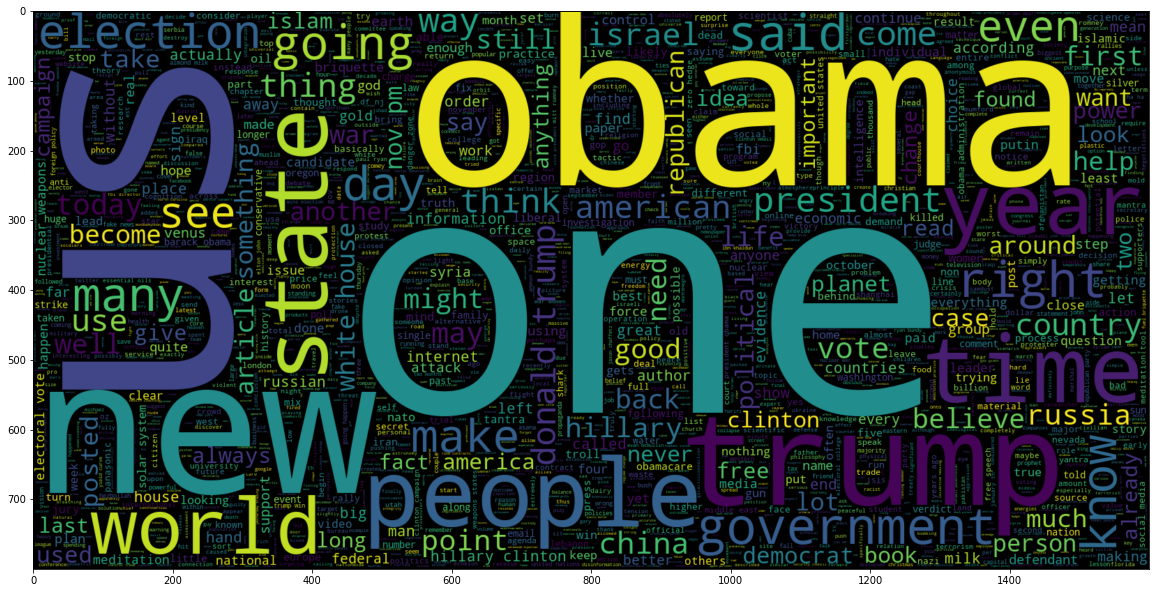

In [8]:
# WORDCLOUD FOR  CLEAN TEXT(LABEL - 1 - True)
plt.figure(figsize=(20, 20))  # Text that is not Fake
wc = wordcloud.WordCloud(max_words=2000, width=1600, height=800, stopwords=wordcloud.STOPWORDS).generate(
    " ".join(train[train.label == 1].content))
plt.imshow(wc, interpolation='bilinear')
plt.show()

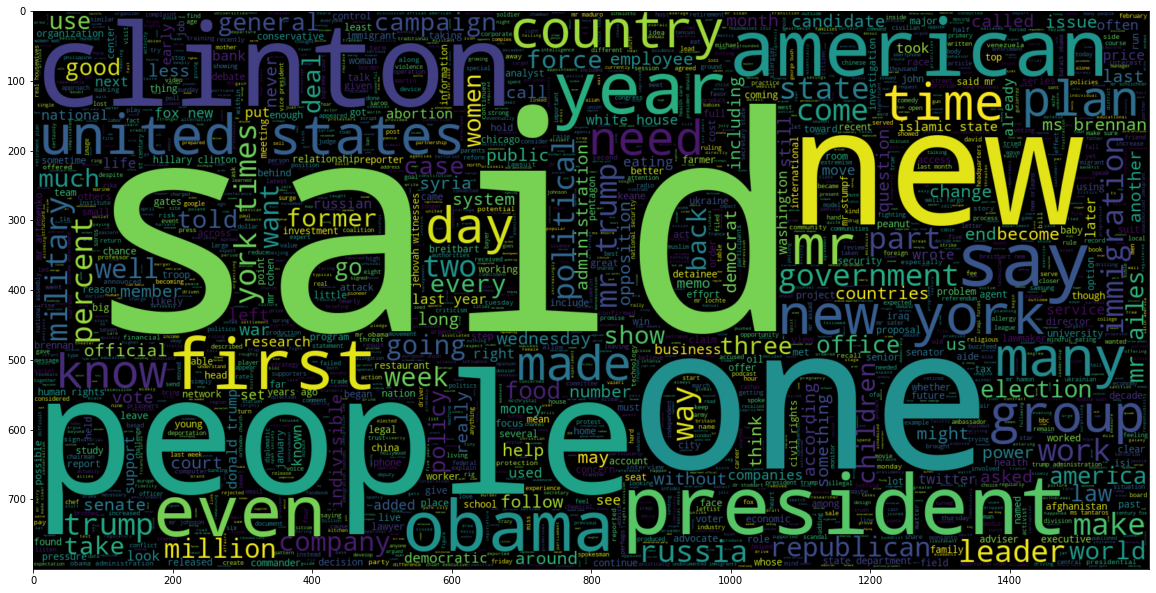

In [9]:
# WORDCLOUD FOR  CLEAN TEXT(LABEL - 0 - fake)
plt.figure(figsize=(20, 20))  # Text that is Fake
wc = wordcloud.WordCloud(max_words=2000, width=1600, height=800, stopwords=wordcloud.STOPWORDS).generate(
    " ".join(train[train.label == 0].content))
plt.imshow(wc, interpolation='bilinear')
plt.show()

In [16]:
# NLP - Tokenize and apply Porter’s Stemmer algorithm
ps = nltk.stem.porter.PorterStemmer()
train['content'] = train['content'].apply(lambda x:' '.join([ps.stem(word) for word in nltk.tokenize.word_tokenize(x)]))
print(train.head())

test['content'] = test['content'].apply(lambda x:' '.join([ps.stem(word) for word in nltk.tokenize.word_tokenize(x)]))
print(test.head())



   label                                            content
0      1  hous dem aid even see comey letter jason chaff...
1      0  ever get feel life circl roundabout rather hea...
2      1  truth might get fire octob tension intellig an...
3      1  video civilian kill singl us airstrik identifi...
4      1  print iranian woman sentenc six year prison ir...
   label                                            content
0      0  palo alto calif year scorn polit process silic...
1      1  russian warship readi strike terrorist near al...
2      0  video nodapl nativ american leader vow stay wi...
3      1  first succeed tri differ sport tim tebow heism...
4      1  min ago view comment like first time histori f...
(20800, 109740)
(5200, 109740)
(20800,)
(5200,)


In [26]:
tfid_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.3)
# returns X sparse matrix of (n_samples, n_features)
x_train = tfid_vectorizer.fit_transform(train['content'].values)
x_test = tfid_vectorizer.transform(test['content'].values)
print(x_train.shape)
print(x_test.shape)
y_train = train['label']
y_test = test['label']
print(y_train.shape)
print(y_test.shape)

(20800, 109680)
(5200, 109680)
(20800,)
(5200,)


In [27]:
#Creating and training  model
model = sklearn.linear_model.PassiveAggressiveClassifier(max_iter=10000, random_state=999, tol=1e-3).fit(x_train,y_train)

In [29]:

train_accuracy=model.score(x_train, y_train)
test_accuracy=model.score(x_test, y_test)

print('train_accuracy=',train_accuracy)
print('test_accuracy=',test_accuracy)



train_accuracy= 1.0
test_accuracy= 0.635576923076923
